In [1]:
import warnings

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


In [3]:
def load_data(mri_path, masks_path, image_size=(256, 256)):
    mri_images = sorted([os.path.join(mri_path, file) for file in os.listdir(mri_path) if file.endswith('.png')])
    mask_images = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.png')])
    
    # Load the images and masks, ensuring that they have a channel dimension
    X = np.array([np.array(Image.open(file).resize(image_size).convert('L'), 'f') for file in mri_images])
    Y = np.array([np.array(Image.open(file).resize(image_size).convert('L'), 'f') for file in mask_images])
    
    # Normalize the images and expand the dimensions to include channel information
    X = np.expand_dims(X, axis=-1) / 255.0  # Normalize and add channel dimension
    Y = np.expand_dims(Y, axis=-1) / 255.0  # Normalize and add channel dimension
    
    return X, Y



In [4]:
mri_path = 'E:/Brain tumor seg/mri'
masks_path = 'E:/Brain tumor seg/masks'
X, Y = load_data(mri_path, masks_path)


In [5]:
# Split into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


In [6]:
# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(x_train, batch_size=32, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)


In [11]:
def unet(input_size=(256, 256, 1), starting_filters=32):
    inputs = Input(input_size)
    
    # Contracting Path
    c1 = Conv2D(starting_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(starting_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(starting_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(starting_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(starting_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(starting_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(starting_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(starting_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(starting_filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(starting_filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive Path
    u6 = Conv2DTranspose(starting_filters*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(starting_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(starting_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(starting_filters*4, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(starting_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(starting_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(starting_filters*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(starting_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(starting_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(starting_filters, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(starting_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(starting_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 32)         320       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 256, 256, 32)         128       ['conv2d_19[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 32)         0         ['batch_normalization_9[

 conv2d_transpose_5 (Conv2D  (None, 64, 64, 128)          131200    ['conv2d_30[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_5 (Concatenate  (None, 64, 64, 256)          0         ['conv2d_transpose_5[0][0]',  
 )                                                                   'conv2d_24[0][0]']           
                                                                                                  
 conv2d_31 (Conv2D)          (None, 64, 64, 128)          295040    ['concatenate_5[0][0]']       
                                                                                                  
 batch_normalization_15 (Ba  (None, 64, 64, 128)          512       ['conv2d_31[0][0]']           
 tchNormalization)                                                                                
          

In [7]:
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K


In [8]:
# Define the Dice coefficient metric function
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy',metrics=['accuracy', MeanIoU(num_classes=2),dice_coef])

# Early stopping and model checkpoint
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint('Unet_mri_segmentation_model.h5', verbose=1, save_best_only=True)



In [17]:
# Train the model
results = model.fit(
    train_generator, 
    steps_per_epoch=len(x_train) // 32, 
    epochs=20, 
    validation_data=(x_val, y_val), 
    validation_steps=len(x_val) // 32,
    callbacks=[earlystopper, checkpointer]
)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9518 - mean_io_u: 0.4927 - dice_coef: 0.0811 
Epoch 1: val_loss improved from inf to 0.21373, saving model to Unet_mri_segmentation_model.h5


C:\Users\asus\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 687s 12s/step - loss: 0.1309 - accuracy: 0.9518 - mean_io_u: 0.4927 - dice_coef: 0.0811 - val_loss: 0.2137 - val_accuracy: 0.9608 - val_mean_io_u: 0.4922 - val_dice_coef: 0.0207
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9812 - mean_io_u: 0.4926 - dice_coef: 0.2193 
Epoch 2: val_loss improved from 0.21373 to 0.15155, saving model to Unet_mri_segmentation_model.h5
57/57 [==============================] - 709s 12s/step - loss: 0.0554 - accuracy: 0.9812 - mean_io_u: 0.4926 - dice_coef: 0.2193 - val_loss: 0.1515 - val_accuracy: 0.9672 - val_mean_io_u: 0.4922 - val_dice_coef: 0.0416
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9823 - mean_io_u: 0.4926 - dice_coef: 0.3139 
Epoch 3: val_loss did not improve from 0.15155
57/57 [==============================] - 706s 12s/step - loss: 0.0472 - accuracy: 0.9823 - mean_io_u: 0.4926 - dice_coef: 0.3139 - val_loss: 0.199

57/57 [==============================] - 725s 13s/step - loss: 0.0189 - accuracy: 0.9896 - mean_io_u: 0.4927 - dice_coef: 0.6892 - val_loss: 0.0234 - val_accuracy: 0.9903 - val_mean_io_u: 0.4926 - val_dice_coef: 0.6996


In [19]:
# Train the model for additional epochs
results_additional = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=30,
    validation_data=(x_val, y_val),
    validation_steps=len(x_val) // 32,
    callbacks=[earlystopper, checkpointer],
    initial_epoch=20  # Start from where you left off
)

Epoch 21/30
57/57 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9898 - mean_io_u: 0.4929 - dice_coef: 0.6927 
Epoch 21: val_loss did not improve from 0.02338
57/57 [==============================] - 709s 12s/step - loss: 0.0185 - accuracy: 0.9898 - mean_io_u: 0.4929 - dice_coef: 0.6927 - val_loss: 0.0242 - val_accuracy: 0.9903 - val_mean_io_u: 0.4922 - val_dice_coef: 0.6506
Epoch 22/30
57/57 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9895 - mean_io_u: 0.4926 - dice_coef: 0.6936 
Epoch 22: val_loss did not improve from 0.02338
57/57 [==============================] - 723s 13s/step - loss: 0.0189 - accuracy: 0.9895 - mean_io_u: 0.4926 - dice_coef: 0.6936 - val_loss: 0.0300 - val_accuracy: 0.9886 - val_mean_io_u: 0.4922 - val_dice_coef: 0.5811
Epoch 23/30
57/57 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9900 - mean_io_u: 0.4929 - dice_coef: 0.7048 
Epoch 23: val_loss improved from 0.02338 to 0.02305, savin

In [20]:
model.save('Unet_seg_final.h5')

In [21]:
model.save('Unet_seg_final.keras')

In [22]:
# Train the model for additional epochs
results_additional = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=40,
    validation_data=(x_val, y_val),
    validation_steps=len(x_val) // 32,
    callbacks=[earlystopper, checkpointer],
    initial_epoch=30  # Start from where you left off
)

Epoch 31/40
57/57 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9909 - mean_io_u: 0.4927 - dice_coef: 0.7466 
Epoch 31: val_loss did not improve from 0.01954
57/57 [==============================] - 711s 13s/step - loss: 0.0152 - accuracy: 0.9909 - mean_io_u: 0.4927 - dice_coef: 0.7466 - val_loss: 0.0216 - val_accuracy: 0.9906 - val_mean_io_u: 0.4924 - val_dice_coef: 0.6785
Epoch 32/40
57/57 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9906 - mean_io_u: 0.4926 - dice_coef: 0.7410 
Epoch 32: val_loss did not improve from 0.01954
57/57 [==============================] - 714s 13s/step - loss: 0.0156 - accuracy: 0.9906 - mean_io_u: 0.4926 - dice_coef: 0.7410 - val_loss: 0.0257 - val_accuracy: 0.9904 - val_mean_io_u: 0.4922 - val_dice_coef: 0.6572
Epoch 33/40
57/57 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9910 - mean_io_u: 0.4928 - dice_coef: 0.7568 
Epoch 33: val_loss did not improve from 0.01954
57/57 [===

In [23]:
model.save('Unet_segmentation_final.h5')

In [ ]:
#Testing the Segmentation model with out post-processing

1/1 [==============================] - 0s 89ms/step


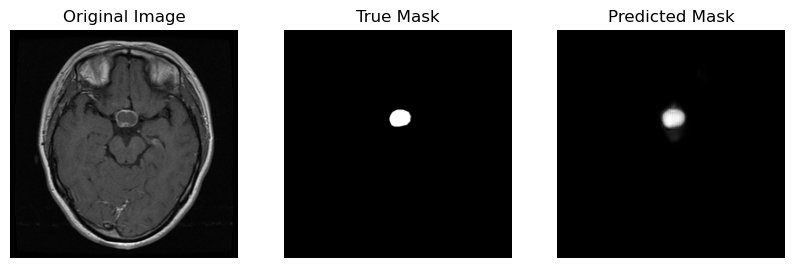

In [21]:
# Load the best saved model
model.load_weights('Unet_mri_segmentation_model.h5')

# Select a random example from the test set
ix = np.random.randint(0, len(x_test))
img = x_test[ix:ix+1]
true_mask = y_test[ix:ix+1]
pred_mask = model.predict(img)

# Plot the results
plt.figure(figsize=(10, 10))

# Original
plt.subplot(1, 3, 1)
plt.imshow(img[0, :, :, 0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

# True Mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[0, :, :, 0], cmap='gray')
plt.title('True Mask')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(pred_mask[0, :, :, 0], cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


In [ ]:
#Testing with Post-processing

1/1 [==============================] - 0s 373ms/step


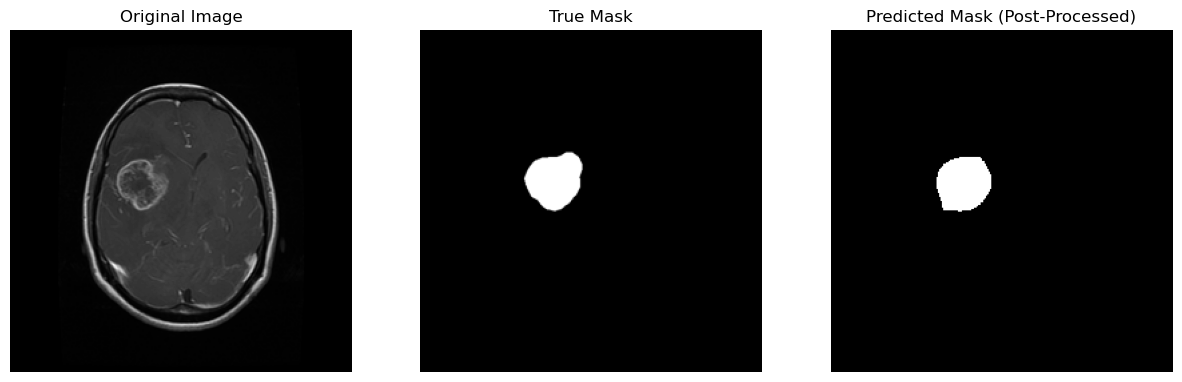

In [22]:
# Define the custom metric function
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Load the pre-trained model with the custom metric function
model = tf.keras.models.load_model('Unet_mri_segmentation_model.h5', custom_objects={'dice_coef': dice_coef})



# Predict on a test image
predicted_mask = model.predict(np.expand_dims(x_test[0], axis=0))

# Post-processing
threshold = 0.5
binarized_mask = (predicted_mask > threshold).astype(np.uint8)  # Thresholding
kernel = np.ones((3, 3), np.uint8)
cleaned_mask = cv2.morphologyEx(binarized_mask[0, :, :, 0], cv2.MORPH_OPEN, kernel)  # Morphological opening

# Show the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(x_test[0, :, :, 0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

# True Mask
plt.subplot(1, 3, 2)
plt.imshow(y_test[0, :, :, 0], cmap='gray')
plt.title('True Mask')
plt.axis('off')

# Predicted Mask After Post-Processing
plt.subplot(1, 3, 3)
plt.imshow(cleaned_mask, cmap='gray')
plt.title('Predicted Mask (Post-Processed)')
plt.axis('off')

plt.show()


In [23]:
# Evaluating Mean Dice_coeff and Mean_iou for test set

def dice_coef(y_true, y_pred, smooth=1e-6):
    # Flatten the array
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.bool)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.bool)
    intersection = tf.logical_and(y_true_f, y_pred_f)
    union = tf.logical_or(y_true_f, y_pred_f)
    iou_score = tf.reduce_sum(tf.cast(intersection, tf.float32)) / tf.reduce_sum(tf.cast(union, tf.float32))
    return iou_score

# Load the pre-trained model with the custom metric function
model = tf.keras.models.load_model('Unet_mri_segmentation_model.h5', custom_objects={'dice_coef': dice_coef})

# Compute Dice and IoU for each image
dice_scores = []
iou_scores = []

for i in range(len(x_test)):
    img = np.expand_dims(x_test[i], axis=0)
    true_mask = y_test[i]
    pred_mask = model.predict(img)
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # Keep predictions as float32
    
    dice_scores.append(dice_coef(true_mask, pred_mask).numpy())
    iou_scores.append(iou(true_mask, pred_mask).numpy())

# Calculate mean metrics
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

print(f'Mean Dice Coefficient: {mean_dice}')
print(f'Mean IoU: {mean_iou}')


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 99ms/step
Mean Dice Coefficient: 0.7524354457855225
Mean IoU: 0.6592278480529785


In [ ]:
# Evaluating Segmentation Model Performance on Medical Images with Visualizations and Metrics

1/1 [==============================] - 0s 91ms/step


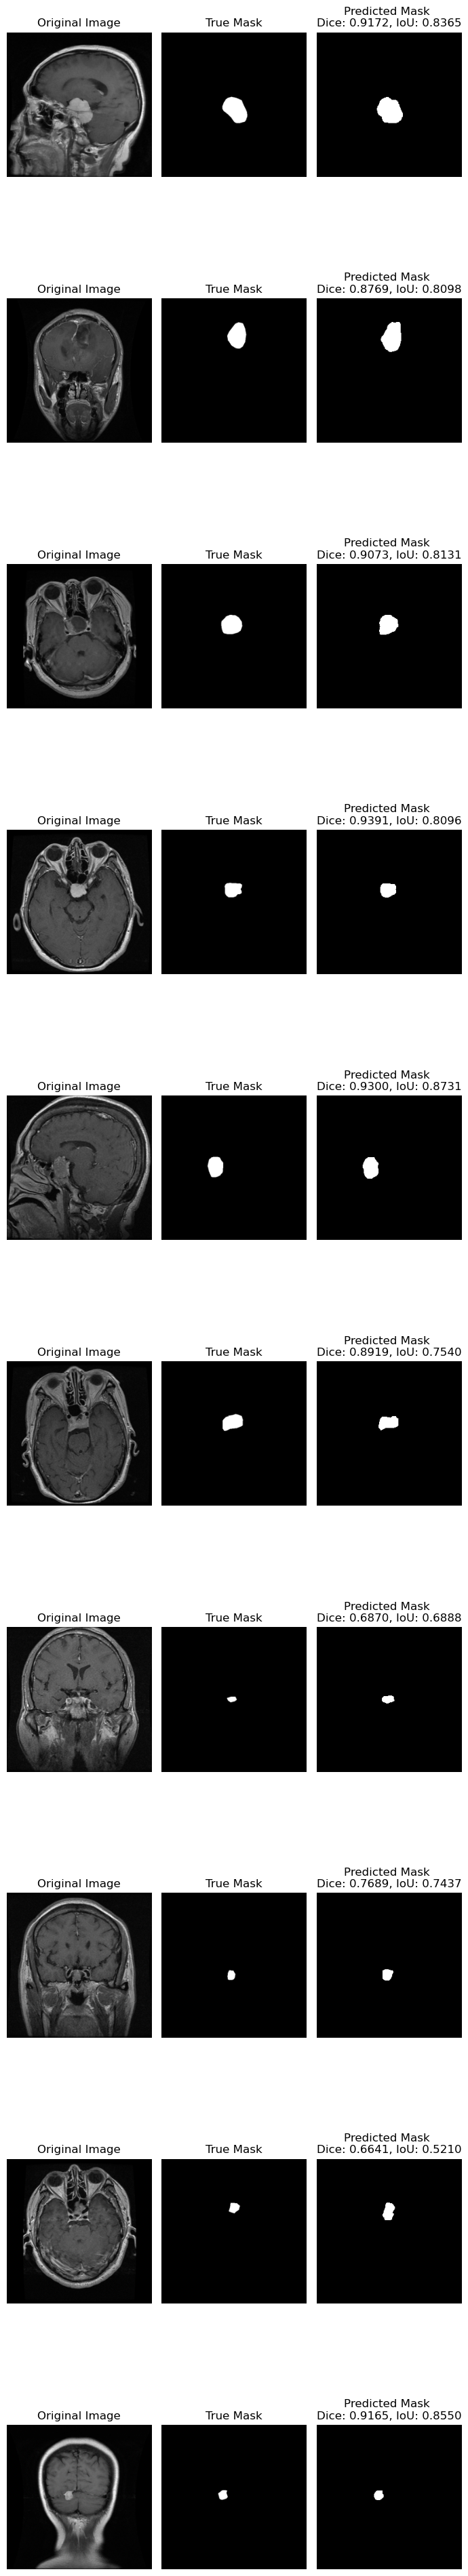

In [29]:
# Randomly select 20 images from the test set
num_images = 10
random_indices = np.random.choice(len(x_test), num_images, replace=False)

# Create subplots
fig, axs = plt.subplots(num_images, 3, figsize=(7, 4 * num_images))

# Define kernel for morphological operation
kernel = np.ones((3, 3), np.uint8)

for i, idx in enumerate(random_indices):
    # Predict the mask for a single image
    img = np.expand_dims(x_test[idx], axis=0)
    true_mask = y_test[idx]
    predicted_mask = model.predict(img)
    
    # Post-processing
    thresholded_mask = (predicted_mask > 0.5).astype(np.uint8)[0, :, :, 0]  # Thresholding and extracting the mask
    post_processed_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_OPEN, kernel)  # Morphological opening
    
    # Calculate Dice Coefficient and IoU
    dice_score = dice_coef(true_mask[:, :, 0], post_processed_mask).numpy()
    iou_score = iou(true_mask[:, :, 0], post_processed_mask).numpy()
    
    # Plot original image
    axs[i, 0].imshow(x_test[idx, :, :, 0], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original Image')
    
    # Plot true mask
    axs[i, 1].imshow(true_mask[:, :, 0], cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('True Mask')
    
    # Plot predicted mask after post-processing
    axs[i, 2].imshow(post_processed_mask, cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title(f'Predicted Mask \nDice: {dice_score:.4f}, IoU: {iou_score:.4f}')

plt.tight_layout()
plt.show()
